# Problem

Problem Statement: Predict future energy consumption patterns based on correlating factors such as temperature, rainfall, and humidity.

In order to do this we will utilize weather and consumption data from 2015 to 2018.

The goal is to be able to predict the energy consumption better than the predicted energy consumption in the dataset.

# Data exploartion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures

#for LSTSM NN
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

## Size and quality of data

Firstly we want to look at the size and quality of the data we have in our dataset. 
This is done by loading the data in pandas dataframes and looking for missing values. 

In [2]:
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

In [3]:
print(energy_df.shape)
print(weather_df.shape)

(35064, 29)
(178396, 17)


As we can see the two dataframes have a lot of rows. We can also see that the weather dataframe is larger than the enegy dataframe. 

In [4]:
energy_df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


It can be observed that the energy dataframe contanins many zeros and NaNs. We check wethere some of the rows only contain zero as null, as these will not be useful for predictions. 

In [5]:
for column in energy_df:
    all_zeros_or_null = (energy_df[column] == 0) | pd.isnull(energy_df[column])
    print(column, ": ", all_zeros_or_null.all())

time :  False
generation biomass :  False
generation fossil brown coal/lignite :  False
generation fossil coal-derived gas :  True
generation fossil gas :  False
generation fossil hard coal :  False
generation fossil oil :  False
generation fossil oil shale :  True
generation fossil peat :  True
generation geothermal :  True
generation hydro pumped storage aggregated :  True
generation hydro pumped storage consumption :  False
generation hydro run-of-river and poundage :  False
generation hydro water reservoir :  False
generation marine :  True
generation nuclear :  False
generation other :  False
generation other renewable :  False
generation solar :  False
generation waste :  False
generation wind offshore :  True
generation wind onshore :  False
forecast solar day ahead :  False
forecast wind offshore eday ahead :  True
forecast wind onshore day ahead :  False
total load forecast :  False
total load actual :  False
price day ahead :  False
price actual :  False


It is observed that multiple columns include only zero or null. These columns are removed before further exploration. 

In [6]:
def check_all_zero(df):
    all_zero_column=[]
    for column in energy_df:
        all_zeros_or_null = (energy_df[column] == 0) | pd.isnull(energy_df[column])
        if all_zeros_or_null.all()==True:
            all_zero_column.append(column)
    return all_zero_column

In [7]:
all_zero_column = check_all_zero(energy_df)
energy_df_0 = energy_df.drop(all_zero_column, axis=1)
energy_df_0.shape

(35064, 21)

Looking into the data by utilizing the describe method. This is a good way to see what values the different columns can take. It is clear that the different features have widely different ranges. In addition some contain many 0s and NaN

In [8]:
energy_df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


We want to look more specifically into our target value "total load actual". Here we can see that the interval for the target is very big wiht a minimum of 18041 and maximum 41015, which are both very big values. 

In [9]:
energy_df['total load actual'].describe()

count    35028.000000
mean     28696.939905
std       4574.987950
min      18041.000000
25%      24807.750000
50%      28901.000000
75%      32192.000000
max      41015.000000
Name: total load actual, dtype: float64

Combine the two dataframes in order to utilize both data. ??? should we do this?

## Distribution of total laod actual by month, weakday and hour
As our goal is to predict the total load actual we will firstly focus on the distribution of this attribute based on month, weakday and hour. This also makes it so that we do not need to focus on all the attributes in the beginning

In [10]:
def pre_process_totalload(df):  
    df["time"] = pd.to_datetime(df["time"] ,utc=True)

    df.set_index('time', inplace=True)
    total_load_df = df[["total load actual"]]

    total_load_df["month"]= df.index.month
    total_load_df["weekday"]= df.index.weekday
    total_load_df["hour"]= df.index.hour
    return total_load_df
total_load_df = pre_process_totalload(energy_df_0)
total_load_df

/var/folders/5c/kj6yt0yn1tlgdrljzqyqr5jc0000gn/T/ipykernel_65623/2171150138.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_load_df["month"]= df.index.month
/var/folders/5c/kj6yt0yn1tlgdrljzqyqr5jc0000gn/T/ipykernel_65623/2171150138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_load_df["weekday"]= df.index.weekday
/var/folders/5c/kj6yt0yn1tlgdrljzqyqr5jc0000gn/T/ipykernel_65623/2171150138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,total load actual,month,weekday,hour
time,,,,
2014-12-31 23:00:00+00:00,25385.0,12,2,23
2015-01-01 00:00:00+00:00,24382.0,1,3,0
2015-01-01 01:00:00+00:00,22734.0,1,3,1
2015-01-01 02:00:00+00:00,21286.0,1,3,2
2015-01-01 03:00:00+00:00,20264.0,1,3,3
...,...,...,...,...
2018-12-31 18:00:00+00:00,30653.0,12,0,18
2018-12-31 19:00:00+00:00,29735.0,12,0,19
2018-12-31 20:00:00+00:00,28071.0,12,0,20


Make boxplots for each, meaning month, weakday and hour. 

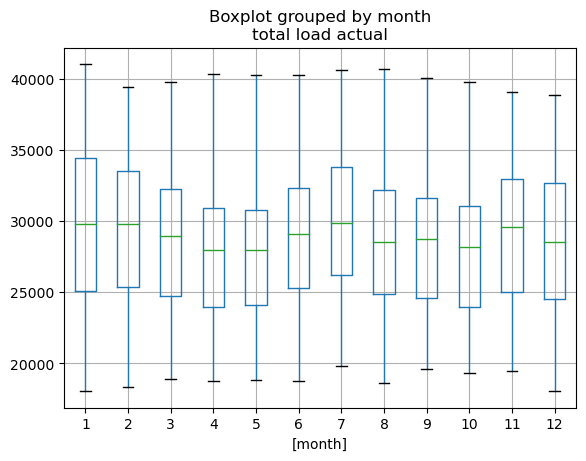

In [11]:
total_load_df[['month', 'total load actual']].boxplot(by='month');

We can see that there is a correlation between the seasons and the power consumption. this means that in the winte time (january, february, november and december) and the summer time (june, july and august) the power consumption is larger than in the spring an autumn. This makes sense due to the extreme temprature, cold and hot respectivly.

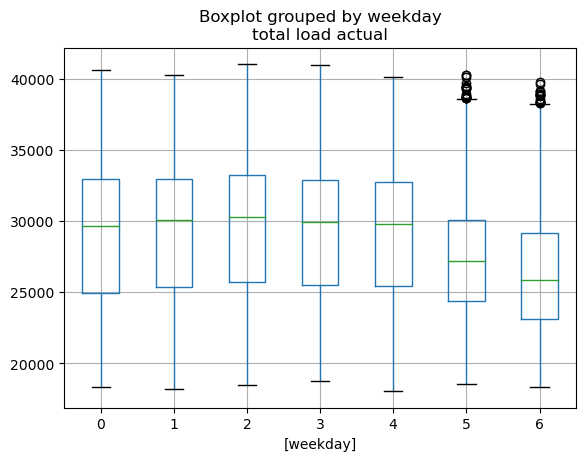

In [12]:
total_load_df[['weekday', 'total load actual']].boxplot(by='weekday');

There is a pattern where the consumption is lower in the weekends than in in the weekdays. This points to the fact that businessess are not open on the weekends, and therfore use less power. Still there are more outliers in the weekends, which needs to be taken into account. 

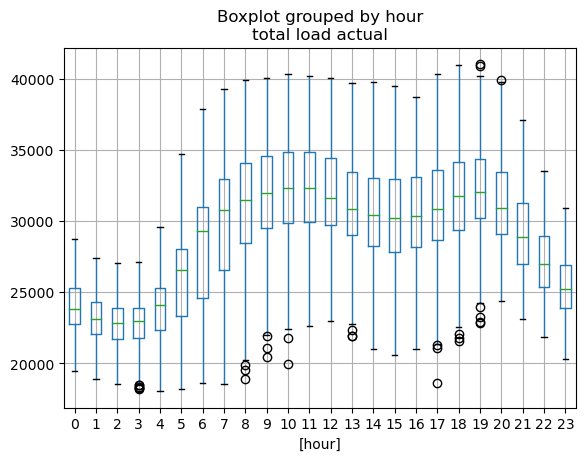

In [13]:
total_load_df[['hour', 'total load actual']].boxplot(by='hour');

It is clear that there is used less power in the night than in daytime, and furthermore there are peaks around 10 and 18.

### Distribution based on month, hour, day

In [14]:
def distribution_type(data, bins, text):
    bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in bins]

    # Use pandas.cut to assign each 'total load actual' value to a bin
    # Use 'loc' to avoid SettingWithCopyWarning
    data.loc[:, 'load_bin'] = pd.cut(data['total load actual'], bins=bins, labels=bin_labels)

    # Count the number of occurrences in each bin
    load_distribution = data['load_bin'].value_counts(sort=False).sort_index()

    # Plot the distribution of 'total load actual' values in a bar chart
    fig, ax = plt.subplots(figsize=(10, 4))
    load_distribution.plot(kind='bar', ax=ax)

    # Set the x-axis and y-axis labels
    ax.set_xlabel('Total Load Actual Bins')
    ax.set_ylabel('Count')
    ax.set_title(text)

    # Show the plot
    plt.show()

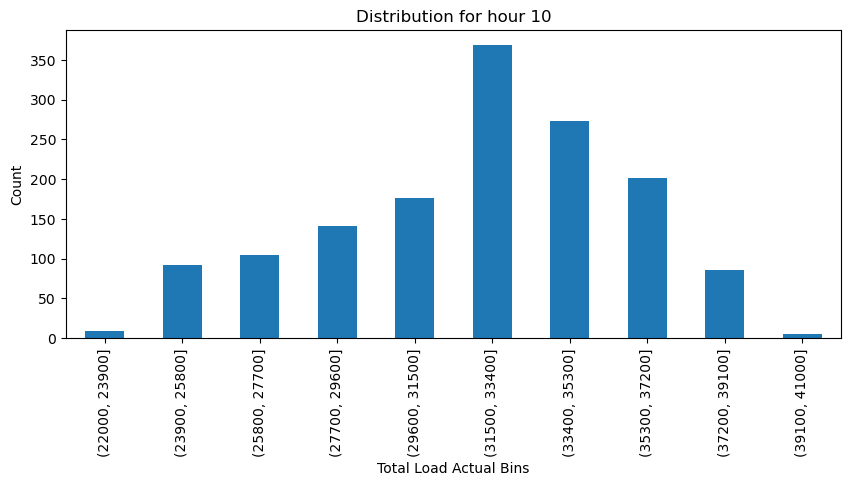

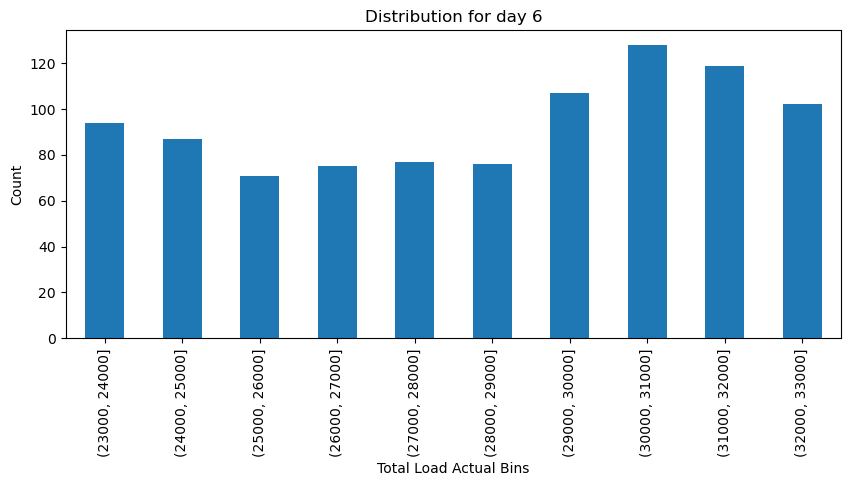

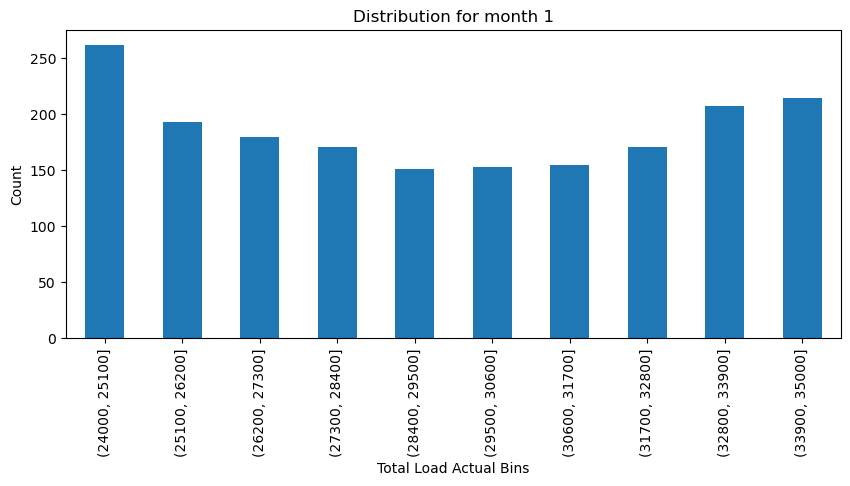

In [15]:

# Assuming total_load_df is already defined and has a DateTimeIndex

# Filter to include only entries at 10:00 AM
ten_am_load = total_load_df[total_load_df.index.hour == 10].copy()  # Make a copy to avoid the warning

# Define the range and bins for 'total load actual' values
bins = pd.interval_range(start=22000, end=41000, periods=10)

distribution_type(ten_am_load, bins, "Distribution for hour 10")

#day
day_2= total_load_df[total_load_df.index.day == 6].copy()
bins = pd.interval_range(start=23000, end=33000, periods=10)
distribution_type(day_2, bins, "Distribution for day 6")

#month
month = total_load_df[total_load_df.index.month == 1].copy()
bins = pd.interval_range(start=24000, end=35000, periods=10)
distribution_type(month, bins, "Distribution for month 1")

It is hard to now exactly what kind of distribution the data have, we can see that the distributions are very different depending on if we focus on hour, day or month. As the distribution for the hour looks like a normal distribution this will be used in later modelling. Because this is an approcimation this can be a reason for error later when utilizing models assuming normal distirbution. 

## Training and test data
Partitioning into training and test set. As we are utilizing a neural network the input features needs to normalized. This is in order for the gradient desent algorithm to find the minimum point. 
(Have not normalized the target variable). 

In addition we saw in the data exploration that there was a large interval in the values of the target value. This means that it can be harder for the neural netowrk to find a minimum point, as the 

In [16]:
total_load_df

,total load actual,month,weekday,hour
time,,,,
2014-12-31 23:00:00+00:00,25385.0,12,2,23
2015-01-01 00:00:00+00:00,24382.0,1,3,0
2015-01-01 01:00:00+00:00,22734.0,1,3,1
2015-01-01 02:00:00+00:00,21286.0,1,3,2
2015-01-01 03:00:00+00:00,20264.0,1,3,3
...,...,...,...,...
2018-12-31 18:00:00+00:00,30653.0,12,0,18
2018-12-31 19:00:00+00:00,29735.0,12,0,19
2018-12-31 20:00:00+00:00,28071.0,12,0,20


In [17]:

total_load_df = pd.get_dummies(total_load_df, columns=['hour'], dtype=int)
total_load_df = total_load_df.dropna()
y_df=total_load_df["total load actual"].astype('float64')
X_df=total_load_df.drop("total load actual", axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_df, test_size=0.33, random_state=42)
input_shape=len(X_df.columns)
energy_df_2 = energy_df.dropna(subset=["total load actual"])

# Normalize target variable
mean_y_train = y_train.mean()
std_y_train = y_train.std()
y_train_normalized = (y_train - mean_y_train) / std_y_train

sep = '2018-01-01'
mean_train = y_train.mean()
std_train = y_train.std()

y_train_normalized = (y_train - mean_train) / std_train
y_test_normalized = (y_test - mean_train) / std_train

In [18]:
total_load_df

,total load actual,month,weekday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,25385.0,12,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2015-01-01 00:00:00+00:00,24382.0,1,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00+00:00,22734.0,1,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00+00:00,21286.0,1,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,20264.0,1,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,30653.0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2018-12-31 19:00:00+00:00,29735.0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2018-12-31 20:00:00+00:00,28071.0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Linear and polynomial regression

We utilize the theory of occam's razor, and therfore start with the simplest regression model we could think of for regression problems. Namly linear and polynomial regression. 

Mean Squared Error (MSE): 9243005.496028358
R-squared Score: 0.5636463875452464


<function matplotlib.pyplot.show(close=None, block=None)>

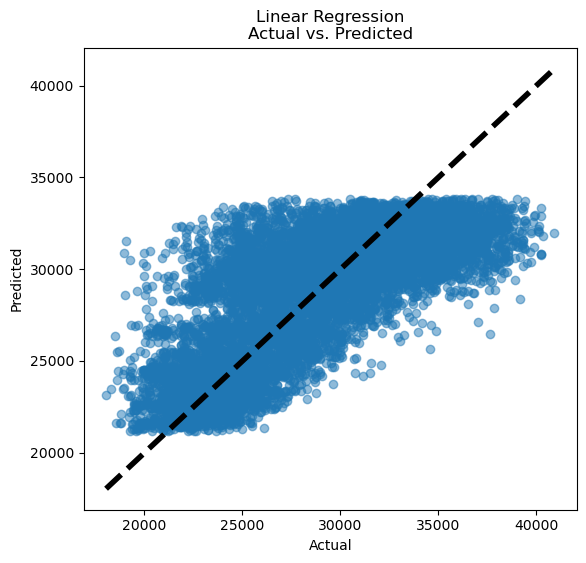

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()

model.fit(X_train, y_train_normalized)

y_pred_normalized = model.predict(X_test)

y_pred = (y_pred_normalized * std_train) + mean_train

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared Score: {r2}")


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Linear Regression\nActual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show

Polynomial Regression MSE: 8152531.281815929
Polynomial Regression R-squared: 0.615126651498872


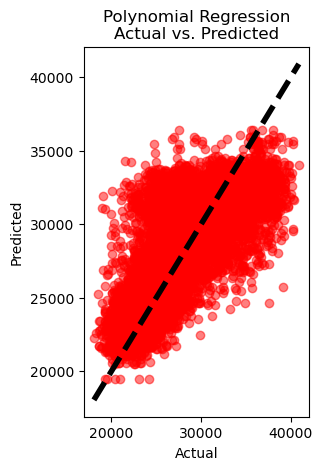

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 3

poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

poly_model.fit(X_train, y_train_normalized)

y_pred_poly_normalized = poly_model.predict(X_test)

y_pred_poly = (y_pred_poly_normalized * std_train) + mean_train

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Polynomial Regression MSE: {mse_poly}")
print(f"Polynomial Regression R-squared: {r2_poly}")


plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_poly, alpha=0.5, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Polynomial Regression\nActual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.show()

Here it is clear that the polynomial regressor works better at approximating the total load actual than the linear regressor, with a lot lower mean squared error. Still the error is very large, meaning the model does not work well.

# Neuroprobabilistic model

As we can see the results are not very good. We therfore look at using other methods. As the data containts a lot of uncertainty, we want to utlize a neuroprobabilistic model. We therfore need to now what kind of distribution the data has. As we saw above we can assume that the data has a normal distirbution. 

In order to use the data for training we want the hours to be one-hot-encoded instead of being between 0-24.

In [21]:
#Seperate training and test set
# sep = '2018-01-01'
# X_train = X_df[X_df.index < sep]
# y_train = y_df[y_df.index < sep]
# X_test = X_df[X_df.index >= sep]
# y_test= y_df[y_df.index >= sep]

We add total load forecast to be used as a baseline for evaluating the model. 

In [22]:
# total_load_forecast_train = energy_df_2[X_df.index < sep]["total load forecast"]
# total_load_forecast_test = energy_df_2[X_df.index >= sep]["total load forecast"]

Create model

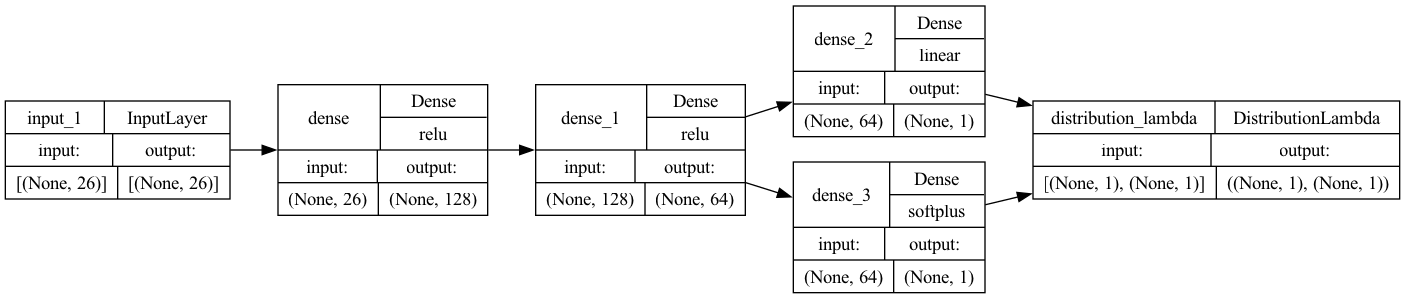

In [23]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    mu = Dense(1)(x)
    sigma = Dense(1, activation=tf.nn.softplus)(x)
    outputs = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t[0], scale=t[1]))([mu, sigma])
    return Model(inputs, outputs)

model = build_model(X_train.shape[1])
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True, rankdir='LR', show_layer_activations=True)

### Training the model

The loss function you are using is the negative log-likelihood (negloglik), which is a common choice for probabilistic models. This function calculates the log probability of the true values according to the predicted distribution and then takes the negative of this value. In probabilistic modeling, the goal is to maximize the log probability of the observed data under the model. Since most optimization algorithms (like gradient descent) are designed to minimize a function, we take the negative of the log-likelihood to turn our maximization problem into a minimization one.

So, a more negative loss means that the model's predicted distribution is getting closer to the true data distribution. This is a good sign that your model is learning. As the model trains and becomes better at predicting the true data distribution, you should expect the negative log-likelihood to decrease (become more negative).

In [24]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss=negloglikelihood)

# Train model
history = model.fit(X_train, y_train_normalized, epochs=20, batch_size=100, verbose=1)

Epoch 1/20
235/235 [==============================] - 0s 677us/step - loss: 0.9585
Epoch 2/20
235/235 [==============================] - 0s 598us/step - loss: 0.8906
Epoch 3/20
235/235 [==============================] - 0s 1ms/step - loss: 0.8780
Epoch 4/20
235/235 [==============================] - 0s 595us/step - loss: 0.8702
Epoch 5/20
235/235 [==============================] - 0s 621us/step - loss: 0.8620
Epoch 6/20
235/235 [==============================] - 0s 593us/step - loss: 0.8547
Epoch 7/20
235/235 [==============================] - 0s 759us/step - loss: 0.8509
Epoch 8/20
235/235 [==============================] - 0s 729us/step - loss: 0.8454
Epoch 9/20
235/235 [==============================] - 0s 623us/step - loss: 0.8413
Epoch 10/20
235/235 [==============================] - 0s 596us/step - loss: 0.8401
Epoch 11/20
235/235 [==============================] - 0s 601us/step - loss: 0.8350
Epoch 12/20
235/235 [==============================] - 0s 601us/step - loss: 0.8288
Epo

In [25]:
from tensorflow.keras.metrics import MeanSquaredError

# Predict on the test set using the model
distribution_predictions = model.predict(X_test)


# We take the mean of the distribution for point predictions
point_predictions = distribution_predictions.mean()

# Initialize the MSE metric
mse = MeanSquaredError()

# Update state of the metric with true values and predicted values
mse.update_state(y_test_normalized, point_predictions)

# Calculate MSE
mean_squared_error = mse.result().numpy()

print(f"Mean Squared Error on the test set: {mean_squared_error}")


362/362 [==============================] - 0s 429us/step
Mean Squared Error on the test set: 1.0182907581329346


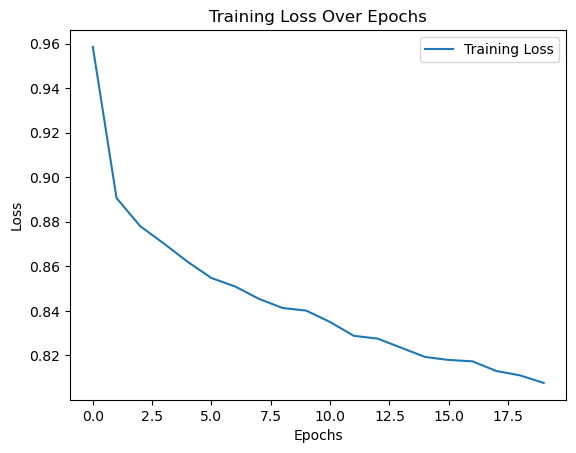

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

279/362 [======================>.......] - ETA: 0s

362/362 [==============================] - 1s 1ms/step


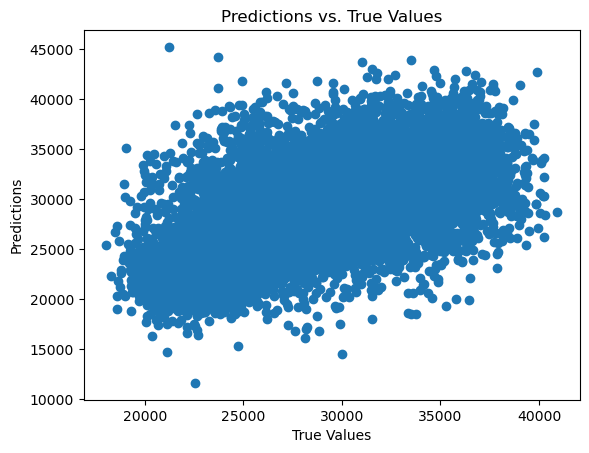

[[26458.102]
 [33429.344]
 [23687.057]
 ...
 [29575.883]
 [23183.82 ]
 [26524.738]]


In [27]:
predictions = model.predict(X_test)
# Apply inverse transformation to bring predictions back to original scale
predictions = predictions * std_train + mean_train

# Plot predictions vs. targets
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()
#util.plot_pred_scatter(y_test, ts_pred, figsize=figsize)
print(predictions)

In [28]:
# Create a DataFrame with the index of X_test
result_df = pd.DataFrame(index=y_test.index)

# Add columns for predictions and true values
result_df['predictions'] = predictions.flatten()  # Flatten the predictions array
result_df['true_values'] = y_test.values #

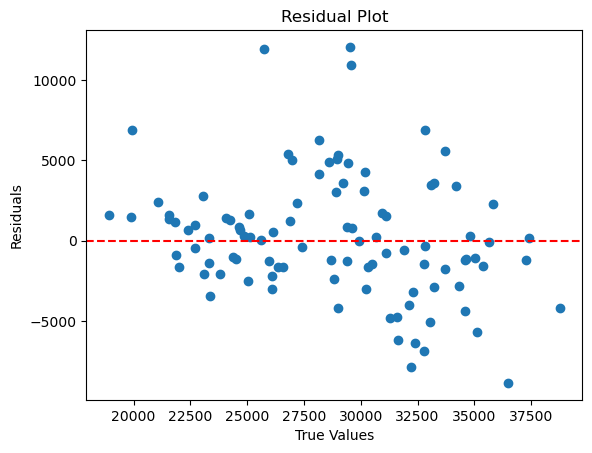

In [29]:

residuals = result_df[0:100]['predictions'] -result_df[0:100]["true_values"]
plt.scatter(result_df[0:100]["true_values"], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

This works very badly, do we need to use more data?

### LSTM NN

The output still had a quit large loss, and we therfore want to try a LSTM Neural network wich works great with time series forecasting.



In [30]:
# Reshape[samples, time steps, features]
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [31]:

def build_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    return model


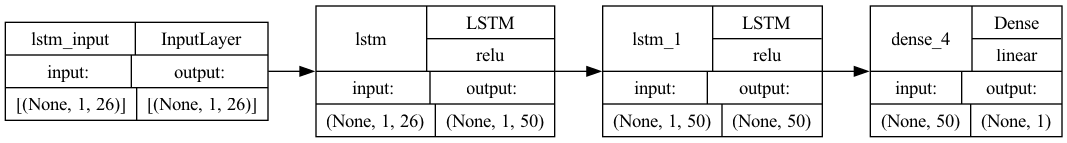

In [32]:
model = build_lstm_model((1, X_train.shape[1]))
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True, rankdir='LR', show_layer_activations=True)

In [33]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_reshaped, y_train_normalized, epochs=200, batch_size=100, verbose=1)


Epoch 1/200


235/235 [==============================] - 2s 2ms/step - loss: 0.5442
Epoch 2/200
235/235 [==============================] - 0s 2ms/step - loss: 0.4134
Epoch 3/200
235/235 [==============================] - 0s 2ms/step - loss: 0.4012
Epoch 4/200
235/235 [==============================] - 1s 2ms/step - loss: 0.3954
Epoch 5/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3931
Epoch 6/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3903
Epoch 7/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3872
Epoch 8/200
235/235 [==============================] - 1s 2ms/step - loss: 0.3850
Epoch 9/200
235/235 [==============================] - 1s 2ms/step - loss: 0.3814
Epoch 10/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3791
Epoch 11/200
235/235 [==============================] - 0s 2ms/step - loss: 0.3776
Epoch 12/200
235/235 [==============================] - 1s 2ms/step - loss: 0.3760
Epoch 13/200
235/235 [===

In [34]:
predictions = model.predict(X_test_reshaped)
#kanksje endre her?
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_normalized, predictions)
print(f'MSE: {mse}')

  1/362 [..............................] - ETA: 44s

362/362 [==============================] - 0s 558us/step
MSE: 0.36024350097055474


In [35]:
# All the code but in one code box

""" X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

model = build_lstm_model(input_shape)

history = model.fit(X_train_reshaped, y_train_normalized, epochs=100, batch_size=72, verbose=2, validation_data=(X_test_reshaped, y_test_normalized))

y_pred = model.predict(X_test_reshaped)

#kanksje endre her?
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_normalized, y_pred)
print(f'MSE: {mse}')
"""

" X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))\nX_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))\n\ndef build_lstm_model(input_shape):\n    model = Sequential()\n    model.add(LSTM(50, activation='relu', input_shape=input_shape))\n    model.add(Dense(1))\n    model.compile(optimizer='adam', loss='mse')\n    return model\n\ninput_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])\n\nmodel = build_lstm_model(input_shape)\n\nhistory = model.fit(X_train_reshaped, y_train_normalized, epochs=100, batch_size=72, verbose=2, validation_data=(X_test_reshaped, y_test_normalized))\n\ny_pred = model.predict(X_test_reshaped)\n\n#kanksje endre her?\nfrom sklearn.metrics import mean_squared_error\nmse = mean_squared_error(y_test_normalized, y_pred)\nprint(f'MSE: {mse}')\n"

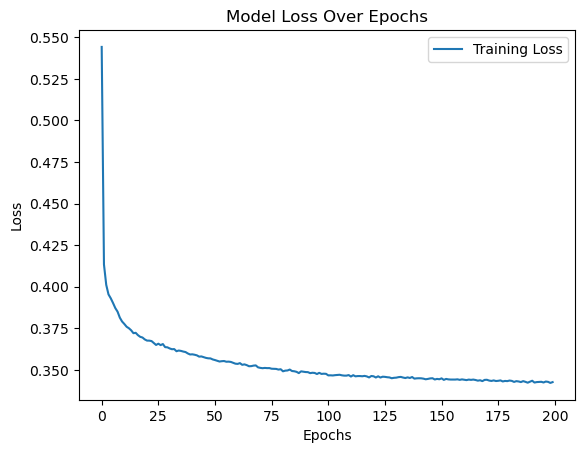

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


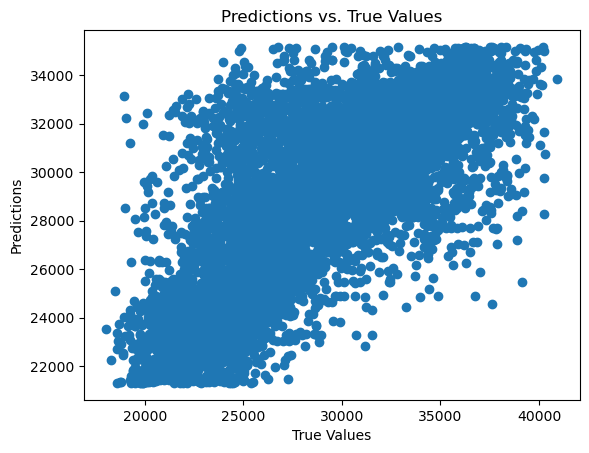

[[31566.71 ]
 [32485.148]
 [23016.992]
 ...
 [35104.125]
 [23755.188]
 [28026.172]]


In [37]:
# Apply inverse transformation to bring predictions back to original scale
predictions = predictions * std_train + mean_train

# Plot predictions vs. targets
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.show()
#util.plot_pred_scatter(y_test, ts_pred, figsize=figsize)
print(predictions)

In [38]:
# Create a DataFrame with the index of X_test
result_df = pd.DataFrame(index=y_test.index)

# Add columns for predictions and true values
result_df['predictions'] = predictions.flatten()  # Flatten the predictions array
result_df['true_values'] = y_test.values #

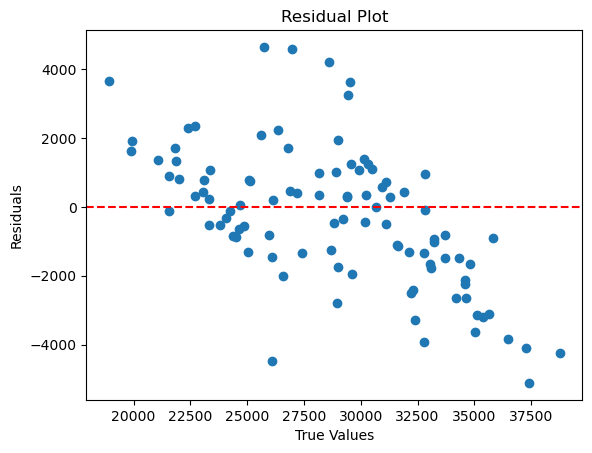

In [39]:

residuals = result_df[0:100]['predictions'] -result_df[0:100]["true_values"]
plt.scatter(result_df[0:100]["true_values"], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Discussion on final results
As we can observe, the LSTM model outperforms the probabilistic neural network. This could be attributed to the assumption of a normal distribution in the data, which isn't supported. Additionally, LSTM excels with time series data, which aligns with our dataset.

However, despite the LSTM's superiority, the error remains considerable, indicating the model's inability to accurately represent the data's function. This might be due to the dataset's high degree of uncertainty, as evidenced by the numerous outliers in the box plot, particularly noticeable in the hourly data, a significant component of the neural network's input features. These outliers can impede the neural network's ability to discern patterns in the data. Consequently, relying solely on time-based information may not suffice to approximate energy consumption accurately, as it is influenced by various other factors.

Nevertheless, throughout this project, it's evident that certain models yield better results compared to others. Therefore, incorporating additional data could potentially enhance the accuracy of predictions. 